# Daymet V4 - Deriving Decadal Normals and Anomalies

*Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, Python, xarray

## Overview
## Source Data
* Annual Climatologies
* Lower Latency

### Requirements
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

***
***

## Tutorial

In this tutorial, we'll demonatrate how to programmatically search for and subset Daymet V4 pre-derived Climatologies.  We'll derive a 30-year decadal Normal and look at the anomaly from that Normal for a recent month of data.

More on Normals - USGS yada yada yada

Steps
* 1. Establish a polygon parameters to use as a boundary file for subsetting Daymet Data
* 2. Programatically search for, subset, and download files of interest
* 3. 
* 4. 


## Step 1.  Polygon Boundary Area Parameters for Subsetting

geopanda version :  0.9.0


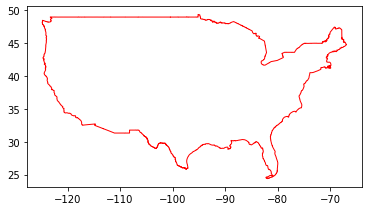

In [1]:
import geopandas as gpd
print("geopanda version : ", gpd.__version__)
conus_poly = gpd.read_file('bnds/conus_singlepart.shp')
ax = conus_poly.plot(color = 'none', edgecolor = 'red')

In [2]:
conus_poly.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

In [13]:
xy = conus_poly.crs.area_of_use.bounds # bound of polygon in lat, lon
print("area_of_use:", xy)
print(' ')
conus_poly_4326 = conus_poly.to_crs(epsg=4326)
xy_4326 = conus_poly_4326.bounds # bound of the conus polygon in lat, lon
print(xy_4326)
print(' ')
xy_list = xy_4326.values.tolist()[0]
print(xy_list)

area_of_use: (167.65, 14.92, -47.74, 86.46)
 
         minx       miny       maxx       maxy
0 -124.848974  24.396308 -66.885075  49.384358
 
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]


In [9]:
xy_list = conus_poly_4326.bounds.values.tolist()[0] # create a python list to pass later as a search parameter
print(xy_list)

[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]


In [14]:
# Do I need this block ??  This seems another way to get the correct bounding box
conus_poly_bounds = conus_poly.bounds # bounding box of the CONUS polygon file 
print('Bbounding box of the CONUS polygon file')
conus_poly_bounds

Bbounding box of the CONUS polygon file


,minx,miny,maxx,maxy
0,-124.848974,24.396308,-66.885075,49.384358


In [15]:
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
conus_poly_lcc = conus_poly.to_crs(daymet_proj) # to_crs re-projects from UTM 17N to LCC
conus_poly_lcc.crs

<Projected CRS: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.31424 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# We'll use the boounding box of the polygon file in Lambert Conformal Conic projection to subset the actual data.  
lccbounds = conus_poly_lcc.bounds # Bounds in LCC projection
print('Projected bounding box of the CONUS polygon file in LCC projection')
lccbounds

Projected bounding box of the CONUS polygon file in LCC projection


,minx,miny,maxx,maxy
0,-1.956186e+06,-1.785922e+06,2.433990e+06,946300.543092


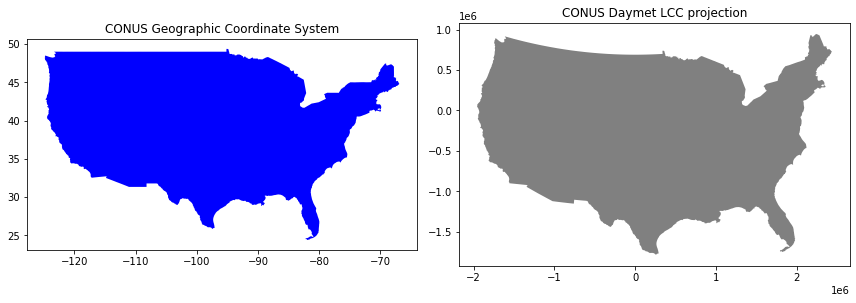

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
conus_poly.plot(ax=ax1, facecolor='blue');
ax1.set_title("CONUS Geographic Coordinate System");
conus_poly_lcc.plot(ax=ax2, facecolor='grey');
ax2.set_title("CONUS Daymet LCC projection");
plt.tight_layout()

## Step 2.  Setting Up Search Parameters - Annual Climatology

We'll use the Dataset DOI of the Daymet V4 Annual Climatologies in this exercise.  These prederived climatologies are available as a unique dataset. 

The [Daymet V4 Annual Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1852) DOI: **doi.org/10.3334/ORNLDAAC/1852**.  

In [26]:
import requests
daymet_doi = '10.3334/ORNLDAAC/1852' # ANNUAL CLIMATES define the DOI as the variable `daymet_doi`
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # 
print('Earthdata Metadata for DaymetV4 Annual Climatologies --> ' , doisearch)

Earthdata Metadata for DaymetV4 Annual Climatologies -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1852


In [19]:
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Cloud-based Concept_ID --> ' , concept_id)

NASA Earthdata Cloud-based Concept_ID -->  C2024906228-ORNL_CLOUD


**We'll set the time period of interest from which to subset data.**

For this exercise, we'll search for and access 30 years of data.

In [22]:
import datetime as dt 
# We'll set up a decadal Normal starting in 1991.
start_date = dt.datetime(1991, 1, 1) # specify your own start date
end_date = dt.datetime(2020, 12, 31)  # specify your end start date

print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)


1991-01-01 00:00:00
2020-12-31 00:00:00
1991-01-01T00:00:00Z,2020-12-31T00:00:00Z


**Now let's look at the search parameters**

In [23]:
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy_list)
print('concept ID      :', concept_id)
print('cmr url         :', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1991-01-01T00:00:00Z,2020-12-31T00:00:00Z
Daymet variable : tmax
bounding box    :
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]
concept ID      : C2024906228-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### Step 2.1 Search for granules within parameters

Now that we've established the search parameters, lets search for files within the dataset that are within our search parameters.

In [24]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(granulesearch) 

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906228-ORNL_CLOUD&page_size=1000&temporal=1991-01-01T00:00:00Z,2020-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999


By clicking on the CMR URL above, you will see NASA's common metadata repository (cmr) for the Daymet V4 Annual Climatologies.  We can search within this to find the individual files (or granules) that we are interested in. 

In [25]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  
granule_names = []

for g in granules:
    granule_name = g['title']
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.nc


**Excellent. We see that we have the years of interest (1991 - 2020) and the variable of interest (tmax), but we'll further reduce this to only the netCDF files (available thru OPeNDAP) below.  Just the North American (na) files are listed because they are within the spatial domain of CONUS that we established in our search.**

### Step 2.2 Programmatically access, subset, and download files

We'll use Pythons **`pydap`** library and the bounding box of the polygon file.

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

Pydap Xarray open_dataset *Parameters*
* **[xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)** 

In [27]:
# Programmatically select for netCDF files
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr

cnt = 0
for g_name in granule_names: 
    if '.nc' in g_name:
        print(' ***GRANULE_NAME*** ---->', g_name)
        thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1852/'
        granule_dap = thredds_url + g_name.replace('Daymet_V4_Annual_Climatology.','')
        #print(granule_dap)
        
        thredds_ds = open_url(granule_dap) #, session=session)  
        #print('thredds_ds ----->', thredds_ds)
        ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")
    
        #print(ds)
        
        temp=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    
        if cnt==0:
            tmax = temp
        else:
            tmax = xr.concat([tmax, temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 time steps; 1991- 2020) to netcdf
tmax.to_netcdf(var + '_concatAnnAvg_conussubset.nc')

 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1999.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_2000.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_2001.nc
 ***GRANULE_NAME*** ----> Daymet

In [ ]:
# DELETE THIS BLOCK FOR WEBINAR
# delete this code block - testing
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr

granule_name = 'daymet_v4_tmax_annavg_na_1991.nc'
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1852/'
granule_dap = thredds_url + granule_name
print(granule_dap)

thredds_ds = open_url(granule_dap)
ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")
print(ds)
print('\n')
print(ds['tmax'])

tmax=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
tmax.to_netcdf(var + '_conussubset.nc')
# DELETE THIS BLOCK FOR WEBINAR

## Step 3. Calculating a 30-year Annual Climate Normal (1991 - 2020)

### Xarray
We'll use Xarray to explore and analyze the 30yr Annual Mean Maximum Temperature dataset we've downloaded.

 Xarry is ...

More on Xarray https://www.youtube.com/watch?v=a339Q5F48UQ
 


### Step 3.1 Explort the 30-year Maximum Temperature File in Xarray

In [28]:
import xarray as xr
ds_tmax_concatAnnAvg = xr.open_dataset('tmax_concatAnnAvg_conussubset.nc') 

#netCDF file representation
ds_tmax_concatAnnAvg.info()

xarray.Dataset {
dimensions:
	time = 30 ;
	x = 4390 ;
	y = 2732 ;

variables:
	float32 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
		x:_ChunkSizes = 7814 ;
	float32 lat(y, x) ;
		lat:units = degrees_north ;
		lat:long_name = latitude coordinate ;
		lat:standard_name = latitude ;
		lat:_ChunkSizes = [1010  977] ;
	float32 lon(y, x) ;
		lon:units = degrees_east ;
		lon:long_name = longitude coordinate ;
		lon:standard_name = longitude ;
		lon:_ChunkSizes = [1010  977] ;
	float32 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
		y:_ChunkSizes = 8075 ;
	float32 tmax(time, y, x) ;
		tmax:units = degrees C ;
		tmax:cell_methods = area: mean time: maximum within days time: mean over days ;
		tmax:long_name = annual average of daily maximum temperature ;
		tmax:_ChunkSizes = [   1 1000 1000] ;
		tmax:grid_mapping = lambert_conformal_conic ;
	datetime64[ns] tim

In [29]:
# Xarray's (html) representation
ds_tmax_concatAnnAvg

<xarray.Dataset>
Dimensions:                  (time: 30, x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
  * time                     (time) datetime64[ns] 1991-07-02T12:00:00 ... 20...
Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 ...

In [30]:
ds_tmax_concatAnnAvg.data_vars

Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 -32767

In [31]:
ds_tmax_concatAnnAvg.tmax[0]

<xarray.DataArray 'tmax' (y: 2732, x: 4390)>
[11993480 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1.955e+06 -1.954e+06 ... 2.433e+06 2.434e+06
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * y        (y) float32 9.46e+05 9.45e+05 9.44e+05 ... -1.784e+06 -1.785e+06
    time     datetime64[ns] 1991-07-02T12:00:00
Attributes:
    units:         degrees C
    cell_methods:  area: mean time: maximum within days time: mean over days
    long_name:     annual average of daily maximum temperature
    _ChunkSizes:   [   1 1000 1000]
    grid_mapping:  lambert_conformal_conic

In [32]:
ds_tmax_concatAnnAvg.tmax.dims
# Here we can see the arrangment of the dimensions.  Time is the first dimension.

('time', 'y', 'x')

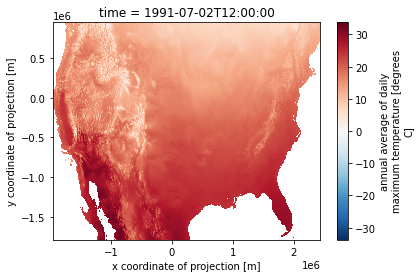

In [34]:
ds_tmax_concatAnnAvg.tmax[0].plot() # Plot the first year (1991) of the 30-year concatenated file

In [36]:
# Looking at the numpy array of tmax data - for one day
ds_tmax_concatAnnAvg.tmax[1].data

#can also look at the values of the coordinates
#ds_tmax_30yr.tmax.x
#ds_tmax_30yr.tmax.y

array([[     nan,      nan,      nan, ..., 9.866959, 9.804055, 9.857589],
       [     nan,      nan,      nan, ..., 9.796384, 9.787452, 9.845096],
       [     nan,      nan,      nan, ..., 9.758657, 9.811069, 9.802301],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)

### 3.2 Derive 30-year Normal for Maximum Temperature

In [37]:
tmax_30yrNormal_1991_2020 = ds_tmax_concatAnnAvg.mean('time')
tmax_30yrNormal_1991_2020

<xarray.Dataset>
Dimensions:                  (x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
Data variables:
    tmax                     (y, x) float32 nan nan nan nan ... nan nan nan nan
    lambert_conformal_conic  float64 -3.277e+04

<AxesSubplot:xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

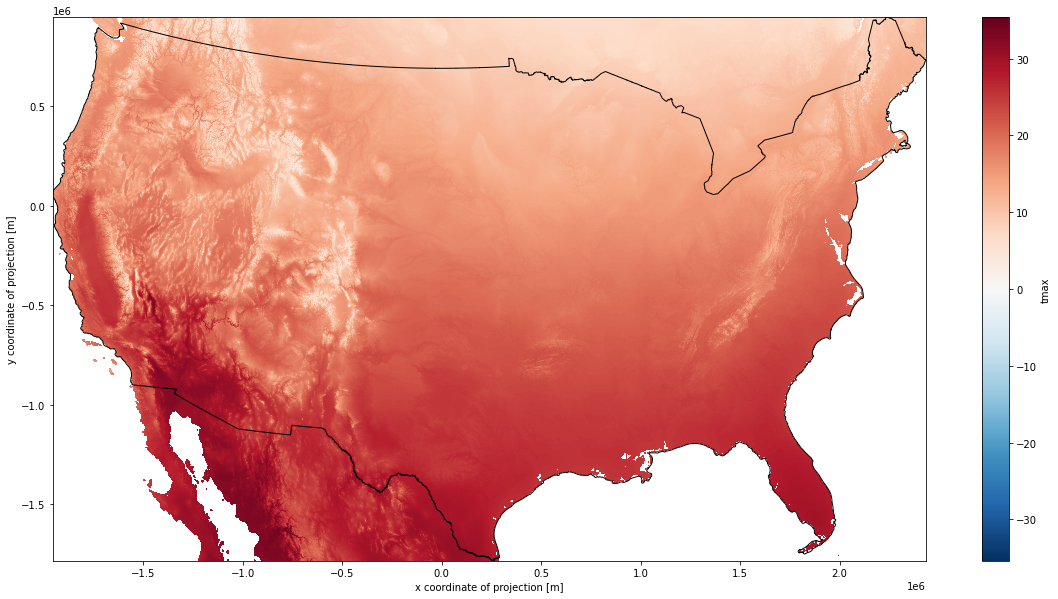

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,10))
tmax_30yrNormal_1991_2020.tmax.plot(ax=ax)
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')

<AxesSubplot:xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

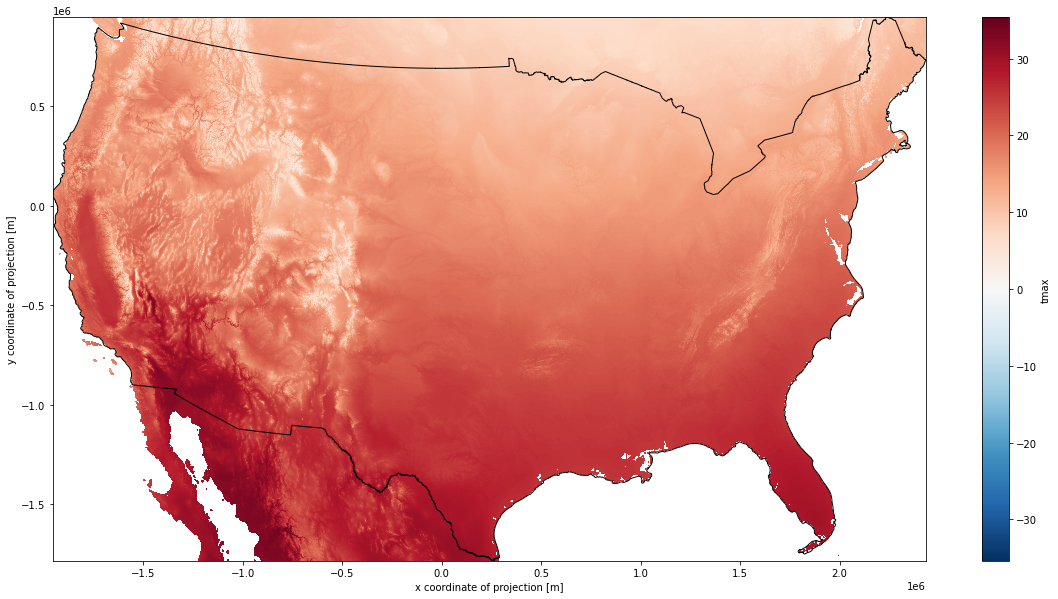

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,10))
tmax_30yrNormal_1991_2020.tmax.plot(ax=ax)
norm = plt.Normalize(vmin=-10, vmax=30)
conus_poly_lcc.plot(ax = ax, norm=norm, color = 'none', edgecolor = 'black')
#conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')

In [ ]:
#save using to_netcdf method

---
---

## Step 3.  Monthly (June) Normal and Anomaly from Daymet V4 Monthly Climatologies

### Step 3.1  Monthly Climatologies - Setting Up Search Parameters

In [51]:
import requests
m_daymet_doi = '10.3334/ORNLDAAC/1855' # Monthly CLIMATES DOI
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
m_doisearch = cmrurl + 'collections.json?doi=' + m_daymet_doi # 
print('Earthdata Metadata for DaymetV4 Monthly Climatologies --> ' , m_doisearch)

m_response = requests.get(m_doisearch)
m_collection = m_response.json()['feed']['entry'][0]
#print(collection)
m_concept_id = m_collection['id']
print('NASA Earthdata Cloud-based Concept_ID Monthly Climates --> ' , m_concept_id)

import datetime as dt 
# We'll set up the same 30year Normal starting in 1991.
start_date = dt.datetime(1991, 1, 1) # specify your own start date
end_date = dt.datetime(2020, 12, 31)  # specify your end start date

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

print(' ')
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy_list)
print('concept ID      :', m_concept_id)
print('cmr url         :', cmrurl)

Earthdata Metadata for DaymetV4 Monthly Climatologies -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1855
NASA Earthdata Cloud-based Concept_ID Monthly Climates -->  C2024906320-ORNL_CLOUD
 
Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1991-01-01T00:00:00Z,2020-12-31T00:00:00Z
Daymet variable : tmax
bounding box    :
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]
concept ID      : C2024906320-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### **Step 3.2 Monthly Climates - Setting up CMR URL with Search Parameters and Making File List**

In [52]:
m_granulesearch = cmrurl + 'granules.json?collection_concept_id=' + m_concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(m_granulesearch)

response = requests.get(m_granulesearch)
m_granules = response.json()['feed']['entry']  
m_granule_names = []

for g in m_granules:
    m_granule_name = g['title']
    if var in m_granule_name:
        m_granule_names.append(m_granule_name)
        print(m_granule_name)

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906320-ORNL_CLOUD&page_size=1000&temporal=1991-01-01T00:00:00Z,2020-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1996.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_mon

### Step 3.2.a Examine one Monthly File to See Internal Structure

In [53]:
# Let's use Xarray to look into *ONE* of the monthly netCDF files to examine the structure of the netCDF file
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr

m_granule_name = 'daymet_v4_tmax_monavg_na_1991.nc'
m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
m_granule_dap = m_thredds_url + m_granule_name
print(m_granule_dap)

m_thredds_ds = open_url(m_granule_dap)
ds_tmax_monavg_na_1991 = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")


## Xarray's html representation
ds_tmax_monavg_na_1991.info()

## with Xarray, can look at individual variables and their attributes
ds_tmax_monavg_na_1991.tmax.attrs

## Either of these will work to examine the time coordinate
#ds_tmax_monavg_na_1991.coords["time"]
ds_tmax_monavg_na_1991.tmax.time

# NOT WORKING ???
#ds_tmax_monavg_na_1991.tmax[0].plot()

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/daymet_v4_tmax_monavg_na_1991.nc
xarray.Dataset {
dimensions:
	nv = 2 ;
	time = 12 ;
	x = 7814 ;
	y = 8075 ;

variables:
	datetime64[ns] time_bnds(time, nv) ;
		time_bnds:_ChunkSizes = [1, 2] ;
	int16 lambert_conformal_conic() ;
		lambert_conformal_conic:false_easting = 0.0 ;
		lambert_conformal_conic:false_northing = 0.0 ;
		lambert_conformal_conic:standard_parallel = [25.0, 60.0] ;
		lambert_conformal_conic:semi_major_axis = 6378137.0 ;
		lambert_conformal_conic:inverse_flattening = 298.257223563 ;
		lambert_conformal_conic:latitude_of_projection_origin = 42.5 ;
		lambert_conformal_conic:grid_mapping_name = lambert_conformal_conic ;
		lambert_conformal_conic:longitude_of_central_meridian = -100.0 ;
	float32 lat(y, x) ;
		lat:units = degrees_north ;
		lat:long_name = latitude coordinate ;
		lat:standard_name = latitude ;
		lat:_ChunkSizes = [1010, 977] ;
	float32 lon(y, x) ;
		lon:units = degrees_east ;
		lon:long_name = longit

<xarray.DataArray 'time' (time: 12)>
array(['1991-01-16T12:00:00.000000000', '1991-02-15T00:00:00.000000000',
       '1991-03-16T12:00:00.000000000', '1991-04-16T00:00:00.000000000',
       '1991-05-16T12:00:00.000000000', '1991-06-16T00:00:00.000000000',
       '1991-07-16T12:00:00.000000000', '1991-08-16T12:00:00.000000000',
       '1991-09-16T00:00:00.000000000', '1991-10-16T12:00:00.000000000',
       '1991-11-16T00:00:00.000000000', '1991-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lambert_conformal_conic  int16 ...
  * time                     (time) datetime64[ns] 1991-01-16T12:00:00 ... 19...
Attributes:
    standard_name:  time
    long_name:      24-hour day based on local time
    _ChunkSizes:    1

In [ ]:
## TEST _ REMOVE CODE BLOCK
tmax_july=ds_tmax_monavg_na_1991['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]), time=slice(dt.datetime(1991, 6, 16), (dt.datetime(1991, 7, 16))))
tmax_july

In [ ]:
# Programmatically select for netCDF files
# Subset and concatenate June files into one netCDF file
# Save file as tmax_concatJuneMonAvg_conussubset.nc - 30 years of June - 1991-2020
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr

#m_granule_name = 'daymet_v4_tmax_monavg_na_1991.nc'
#m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
#m_granule_dap = thredds_url + m_granule_name
#print(m_granule_dap)

#m_thredds_ds = open_url(m_granule_dap)
#ds_tmax_monavg_na_1991 = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")

cnt = 0
for m_g_name in sorted(m_granule_names): 

    if '.nc' in m_g_name:
        print(' ***GRANULE_NAME*** ---->', m_g_name)
        m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
        m_granule_dap = m_thredds_url + m_g_name.replace('Daymet_V4_Monthly_Climatology.','')
        #print(m_granule_dap)
        
        m_thredds_ds = open_url(m_granule_dap) #, session=session)  
        m_ds = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")
        #print(m_ds)
        
        yr = m_ds.start_year
        m_temp=m_ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]),time=slice(dt.datetime((yr), 6, 16), (dt.datetime((yr), 7, 16))))
        if cnt==0:
            m_tmax = m_temp
        else:
            m_tmax = xr.concat([m_tmax, m_temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 June time steps; 1991- 2020) to netcdf
m_tmax.to_netcdf(var + '_concatJuneMonAvg_conussubset.nc')

In [ ]:
# July 1991 - 20202
# Programmatically select for netCDF files
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr

cnt = 0
for m_g_name in sorted(m_granule_names): 

    if '.nc' in m_g_name:
        print(' ***GRANULE_NAME*** ---->', m_g_name)
        m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
        m_granule_dap = m_thredds_url + m_g_name.replace('Daymet_V4_Monthly_Climatology.','')
        #print(granule_dap)
        
        m_thredds_ds = open_url(m_granule_dap) #, session=session)  
        #print('thredds_ds ----->', thredds_ds)
        m_ds = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")

        #print(ds)
        yr = m_ds.start_year
        m_temp=m_ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]),time=slice(dt.datetime((yr), 7, 16), (dt.datetime((yr), 8, 16))))
        if cnt==0:
            m_tmax = m_temp
        else:
            m_tmax = xr.concat([m_tmax, m_temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 July time steps; 1991- 2020) to netcdf
m_tmax.to_netcdf(var + '_concatJulyMonAvg_conussubset.nc')

In [ ]:
## from above just for tracking:  m_tmax.to_netcdf(var + '_concatJuneMonAvg_conussubset.nc')
ds_tmax_concatJuneMonAvg = xr.open_dataset('tmax_concatJuneMonAvg_conussubset.nc') 

#netCDF file representation
#ds_tmax_concatJuneMonAvg.info()

In [ ]:
# Let's look at the time coordinate for the concatenated file
ds_tmax_concatJuneMonAvg.tmax.time

In [ ]:
# Here we are deriving and plotting the 30yr Normal for the month of June
tmax_30yrJuneNormal_1991_2020 = ds_tmax_concatJuneMonAvg.mean('time')


#tmax_30yrJulyNormal_1991_2020.tmax.plot()
import matplotlib.pyplot as plt
tmax_1 = tmax_30yrJuneNormal_1991_2020.tmax
fig, ax = plt.subplots(figsize = (20,10))
tmax_1.plot(ax=ax, cbar_kwargs={'label': 'degrees C'})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')
fig.suptitle('Maximum Temperature - June - 30 Year Normal', fontsize=24)

In [ ]:
tmax_30yrJuneNormal_1991_2020 = ds_tmax_concatJuneMonAvg.mean('time')
tmax_30yrJuneNormal_1991_2020.to_netcdf('tmaxJune30yrNormal91_20.nc')


In [ ]:
ds_tmax_concatJulyMonAvg = xr.open_dataset('tmax_concatJulyMonAvg_conussubset.nc') 
# Here we are deriving and plotting the 30yr Normal for the month of July
tmax_30yrJulyNormal_1991_2020 = ds_tmax_concatJulyMonAvg.mean('time')

#tmax_30yrJulyNormal_1991_2020.tmax.plot()
import matplotlib.pyplot as plt
tmax_2 = tmax_30yrJulyNormal_1991_2020.tmax
fig, ax = plt.subplots(figsize = (20,10))
tmax_2.plot(ax=ax, cbar_kwargs={'label': 'degrees C'})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')
fig.suptitle('Maximum Temperature - July - 30 Year Normal', fontsize=24)

In [ ]:
tmax_30yrJuneNormal_1991_2020.info()

In [ ]:
tmax_30yrJuneNormal_1991_2020.to_netcdf(var + '_30yrJuneNormal_conus.nc')

##  Daymet V4 Daily Files - Monthly Lower Latency

For 2021, Daymet V4 Daily data are now being produced on a monthly update cycle.

Those [data](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1904/catalog.html) are, at the time of this webinar, hosted on the ORNL DAAC THREDDS Data Server and through [OPeNDAP](https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc) 

A sample file name is:  **daymet_v4ll_daily_na_tmax_202106.nc**

In [ ]:
# OPeNDAP URL : https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc
ll_granule_name = 'daymet_v4ll_daily_na_tmax_202106.nc'
ll_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/'
ll_granule_dap = ll_thredds_url + ll_granule_name
print(ll_granule_dap)

ll_thredds_ds = open_url(ll_granule_dap)
ds_tmax_202106 = xr.open_dataset(xr.backends.PydapDataStore(ll_thredds_ds), decode_coords="all")
print(ds_tmax_202106)
#print('\n')
#print(ds_tmax_202106['tmax'])


In [ ]:
## Subset the July 2021 file to CONUS

tmax_202106_conus=ds_tmax_202106['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
tmaxavg_202106_conus = tmax_202106_conus.mean('time')

tmaxavg_202106_conus.to_netcdf(var + '_avg_202106_conus.nc') #Do we need to save this to netCDF here?  


In [ ]:
tmaxavg_202106_conus.plot()

In [ ]:
# tmaxJune30yrNormal91_20.nc
# tmax_avg_202106_conus.nc
ds_tmax_30yrJuneNormal = xr.open_dataset('tmaxJune30yrNormal91_20.nc')
ds_tmax_avg_202106 = xr.open_dataset('tmax_avg_202106_conus.nc')
tmax_June2021_Anomaly = (ds_tmax_avg_202106['tmax'] -ds_tmax_30yrJuneNormal['tmax'])
tmax_June2021_Anomaly.to_netcdf('tmax_June2021_anomaly_30yrJune91_20.nc')

tmax_June2021_Anomaly.plot()
# tmax_anon = tmax_June2021_Anomaly.tmax
fig, ax = plt.subplots(figsize = (20,10))
tmax_1.plot(ax=ax, cbar_kwargs={'label': 'degrees C'})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')


#import matplotlib.pyplot as plt
#tmax_1 = tmax_30yrJuneNormal_1991_2020.tmax
#fig, ax = plt.subplots(figsize = (20,10))
#tmax_1.plot(ax=ax, cbar_kwargs={'label': 'degrees C'})
#conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')
#fig.suptitle('Maximum Temperature - June - 30 Year Normal', fontsize=24)